In [4]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy import integrate
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import functools
import os
import math
import functools
import string
import wandb
from tqdm import tqdm


import sys
from utils import Config

In [228]:
config = Config()

config.device = 'cpu'

config.sampling = Config()
config.sampling.method = 'ode'


config.sampling.ode_solver = 'rk45'
config.sampling.N = 100
config.sampling.z_max = 6
config.sampling.z_min = 1e-3
config.sampling.upper_norm = 12

config.sampling.z_exp = 1
# verbose
config.sampling.vs = False


config.data = Config()
config.data.num_channels = 3
config.data.channels = 2
config.data.centered = True
config.data.img_resize = 1
config.data.image_size = 1




config.training = Config()
config.training.sde = 'poisson'
config.training.continuous = True
config.training.batch_size = 256#4096
config.training.small_batch_size = 256
config.training.gamma = 5
config.training.restrict_M = True
config.training.tau = 0.03
config.training.snapshot_freq = 1_000
config.training.eval_freq = 1_000
config.training.model = 'ddpmpp'
config.training.M = 291
config.training.reduce_mean = False
config.training.n_iters =  20_000


config.model  = Config()

config.model.name = 'ncsnpp'
config.model.scale_by_sigma = False
config.model.ema_rate = 0.9999
config.model.normalization = 'GroupNorm'
config.model.nonlinearity = 'swish'
config.model.nf = 128
config.model.ch_mult = (1, 2, 2, 2)
config.model.num_res_blocks = 4
config.model.attn_resolutions = (16,)
config.model.resamp_with_conv = True
config.model.conditional = True
config.model.fir = False
config.model.fir_kernel = [1, 3, 3, 1]
config.model.skip_rescale = True
config.model.resblock_type = 'biggan'
config.model.progressive = 'none'
config.model.progressive_input = 'none'
config.model.progressive_combine = 'sum'
config.model.attention_type = 'ddpm'
config.model.init_scale = 0.
config.model.fourier_scale = 16
config.model.embedding_type = 'positional'
config.model.conv_size = 3
config.model.sigma_end = 0.01
config.model.dropout = 0.1

config.optim  = Config()
config.optim.weight_decay = 0
config.optim.optimizer = 'Adam'
config.optim.lr = 2e-4

config.optim.beta1 = 0.9
config.optim.eps = 1e-8
config.optim.warmup = 5000
config.optim.grad_clip = 1.

## Functions input

In [2]:
import torch
import numpy as np

def loss_pfgm(model, batch, labels=None, num_classes = 3, uncond_prob=0.2):

    samples_full = batch
    samples_batch = batch[: sde.config.training.small_batch_size]

    m = torch.rand((samples_batch.shape[0],), device=samples_batch.device) * sde.M
    perturbed_samples_vec = forward_pz(sde, sde.config, samples_batch, m)

    uncond_label_idx = num_classes

    if labels is not None:
        mask = np.random.choice(np.arange(2), replace=True, size=samples_batch.shape[0], p=[1 - uncond_prob, uncond_prob]).astype(bool)
        batch_labels = labels[:samples_batch.shape[0]].clone()
        batch_labels[mask] = uncond_label_idx
        labels_onehot = (batch_labels[:, None] == torch.arange(num_classes + 1, device=labels.device)[None, :]).float()
        full_labels = labels

    else:
        batch_labels = torch.full((samples_batch.shape[0],), num_classes, device=samples_batch.device)
        full_labels = torch.full((samples_full.shape[0],), num_classes, device=samples_full.device)

        labels_onehot = torch.zeros((samples_batch.shape[0], num_classes + 1), device=samples_batch.device)
        # Use variable for unconditional index
        labels_onehot[:, uncond_label_idx] = 1.0

    with torch.no_grad():
        real_samples_vec = torch.cat(
          (samples_full.reshape(len(samples_full), -1),
           torch.zeros((len(samples_full), 1)).to(samples_full.device)), dim=1)

        data_dim = sde.config.data.image_size * sde.config.data.image_size * sde.config.data.channels

        # Get unconditional samples (for fallback)
        uncond_samples = real_samples_vec # Renamed for clarity, used when needed

        # Initialize target tensor
        target = torch.zeros_like(perturbed_samples_vec)

        # Calculate target for each label group separately
        # Loop up to num_classes + 1
        for label_idx in range(num_classes + 1):
            # Get indices of samples with current label in the small batch
            batch_mask = (batch_labels == label_idx)

            # Skip if no samples with this label in the small batch
            if not torch.any(batch_mask):
                continue

            # Select real samples based on label
            # Use variable for unconditional index check
            if label_idx == uncond_label_idx:  # Unconditional - use all samples
                filtered_real = uncond_samples
            else:
                # For conditional, use only samples with matching label
                full_mask = (full_labels == label_idx)

                # If no matching samples in full batch, fall back to unconditional
                if not torch.any(full_mask):
                    # print(f"Warning: No samples found for label {label_idx} in the full batch. Falling back to unconditional.") # Original warning logic removed as requested
                    filtered_real = uncond_samples
                else:
                    filtered_real = real_samples_vec[full_mask]

            # Added safety check in case filtered_real is empty even after fallback attempt
            if filtered_real.shape[0] == 0:
                 continue

            # Get current perturbed samples
            curr_perturbed = perturbed_samples_vec[batch_mask]

            # Calculate distances
            # Using torch.cdist for potentially better efficiency/stability
            distances = torch.sum((curr_perturbed.unsqueeze(1) - filtered_real) ** 2, dim=-1).sqrt()

            # For numerical stability
            min_dist, _ = torch.min(distances, dim=1, keepdim=True)
            # Add epsilon to denominator distances
            distances = min_dist / (distances + 1e-7)
            distances = distances ** (data_dim + 1)

            # Normalize coefficients
            # Add epsilon to sum
            coeff = distances / (torch.sum(distances, dim=1, keepdim=True) + 1e-7)

            # Calculate direction
            # Corrected direction calculation: real - perturbed
            diff = filtered_real.unsqueeze(0) - curr_perturbed.unsqueeze(1) # Broadcasting

            # Calculate Poisson field
            gt_direction = torch.sum(coeff.unsqueeze(-1) * diff, dim=1)

            # Normalize
            gt_norm = gt_direction.norm(p=2, dim=1, keepdim=True)
            gt_direction = gt_direction / (gt_norm + sde.config.training.gamma)
            gt_direction = gt_direction * np.sqrt(data_dim)

            # Assign to target
            target[batch_mask] = gt_direction

    perturbed_samples_x = perturbed_samples_vec[:, :-1].view_as(samples_batch)
    # Clamped z for potential stability
    perturbed_samples_z = torch.clamp(perturbed_samples_vec[:, -1], min=1e-5)

    # Pass the one-hot encoded labels to the model
    # Ensure model signature matches (x, z, labels_onehot)
    net_x, net_z = model(perturbed_samples_x, perturbed_samples_z, labels_onehot) # Pass labels_onehot

    net_x = net_x.view(net_x.shape[0], -1)
    # Ensure net_z is correctly shaped before cat
    net = torch.cat([net_x, net_z.unsqueeze(-1)], dim=1)
    loss = ((net - target) ** 2)
    loss = torch.mean(loss)

    return loss

In [233]:
def forward_pz(sde, config, samples_batch, m):

    """Perturbing the augmented training data. See Algorithm 2 in PFGM paper.

    Args:
      sde: An `methods.SDE` object that represents the forward SDE.
      config: configurations
      samples_batch: A mini-batch of un-augmented training data
      m: A 1D torch tensor. The exponents of (1+\tau).

    Returns:
      Perturbed samples
    """

    data_dim = config.data.channels * config.data.image_size * config.data.image_size # N
    tau = config.training.tau
    z = torch.randn((len(samples_batch), 1, 1, 1)).to(samples_batch.device) * config.model.sigma_end  # [B,1,1,1]
    z = z.abs() # [B,1,1,1]


    # Confine the norms of perturbed data.
    # see Appendix B.1.1 of https://arxiv.org/abs/2209.11178
    if config.training.restrict_M:
        idx = (z < 0.005).squeeze()
        num = int(idx.int().sum())
        restrict_m = int(sde.M * 0.7)
        m[idx] = torch.rand((num,), device=samples_batch.device) * restrict_m


    multiplier = (1+tau) ** m # torch.Size([B])
    # Perturb z
    perturbed_z = z.squeeze() * multiplier # torch.Size([B])* torch.Size([B]) = torch.Size([B])


    ####### perturbation for x component #######

    # Sample uniform angle
    gaussian = torch.randn(len(samples_batch), data_dim).to(samples_batch.device) # torch.Size([B, C*H*W])
    unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True) #  torch.Size([B, C*H*W])

    # injected noise amount
    noise = torch.randn_like(samples_batch).reshape(len(samples_batch), -1) * config.model.sigma_end #torch.Size([B, C*H*W])
    norm_m = torch.norm(noise, p=2, dim=1) * multiplier # torch.Size([B])*torch.Size([B]) = torch.Size([B])


    # Construct the perturbation for x
    perturbation_x = unit_gaussian * norm_m[:, None] # torch.Size([B,C*H*W])* torch.Size([B,1])=  torch.Size([B,C*H*W])
    perturbation_x = perturbation_x.view_as(samples_batch) # torch.size([B,C,H,W])

    # Perturb x
    perturbed_x = samples_batch + perturbation_x # torch.size([B,C,H,W])

    # Augment the data with extra dimension z
    perturbed_samples_vec = torch.cat((perturbed_x.reshape(len(samples_batch), -1),
                                       perturbed_z[:, None]), dim=1)

    # concatenate: torch.Size([B,C*H*W], torch.Size([[B,1]]) = torch.Size([B,C*H*W + 1]
    return perturbed_samples_vec

In [235]:
class Poisson():
    def __init__(self, config):
        """Construct a PFGM.

        Args:
          config: configurations
        """
        self.config = config
        self.N = config.sampling.N


    @property
    def M(self):
        return self.config.training.M


    def prior_sampling(self, batch_size, device='cpu'):
        """
        Sampling initial data from p_prior for 2D Gaussian distributions.
        Adapted from PFGM's image-based implementation.
        """
        # Basic parameters
        max_z = self.config.sampling.z_max  # Maximum z value
        N = self.config.data.channels * self.config.data.image_size * self.config.data.image_size + 1

        # Sampling from inverse-beta distribution
        samples_norm = np.random.beta(a=N / 2. - 0.5, b=0.5, size=batch_size)
        inverse_beta = samples_norm / (1 - samples_norm)

        # Sampling from p_radius(R) by change-of-variable
        samples_norm = np.sqrt(max_z ** 2 * inverse_beta)

        # Clip the sample norm (radius)
        upper_norm = self.config.sampling.upper_norm  # Adjust as needed
        samples_norm = np.clip(samples_norm, 1, upper_norm)
        samples_norm = torch.from_numpy(samples_norm).to(device).view(batch_size, -1)

        # Uniformly sample the angle direction
        # print(batch_size)
        gaussian = torch.randn(batch_size, N - 1).to(device)  # N-1 = 2 dimensions
        unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True)

        # Radius times the angle direction
        init_samples = unit_gaussian * samples_norm

        return init_samples.float()

    def ode(self, net_fn, x, t, class_labels, cfg = 0.0):

        z = np.exp(t.mean().cpu())
        if self.config.sampling.vs:
            print(z)
        x_drift_cond, z_drift_cond = net_fn(x, torch.ones((len(x))).cpu() * z, class_labels)

        uncond_labels = torch.zeros_like(class_labels)
        uncond_labels[:, -1] = 1.0



        x_drift_uncond, z_drift_uncond = net_fn(x, torch.ones((len(x))).cpu() * z, uncond_labels)
        x_drift = x_drift_cond + cfg * (x_drift_cond - x_drift_uncond)
        z_drift = z_drift_cond + cfg * (z_drift_cond - z_drift_uncond)
        x_drift = x_drift.view(len(x_drift), -1)

        # Substitute the predicted z with the ground-truth
        # Please see Appendix B.2.3 in PFGM paper (https://arxiv.org/abs/2209.11178) for details
        z_exp = self.config.sampling.z_exp
        if z < z_exp and self.config.training.gamma > 0:
            data_dim = self.config.data.image_size * self.config.data.image_size * self.config.data.channels
            sqrt_dim = np.sqrt(data_dim)
            norm_1 = x_drift.norm(p=2, dim=1) / sqrt_dim
            x_norm = self.config.training.gamma * norm_1 / (1 -norm_1)
            x_norm = torch.sqrt(x_norm ** 2 + z ** 2)
            z_drift = -sqrt_dim * torch.ones_like(z_drift) * z / (x_norm + self.config.training.gamma)

        # Predicted normalized Poisson field
        v = torch.cat([x_drift, z_drift[:, None]], dim=1)

        dt_dz = 1 / (v[:, -1] + 1e-5)
        dx_dt = v[:, :-1]
        # .view(len(x), self.config.data.num_channels,
                          # self.config.data.image_size, self.config.data.image_size)
        dx_dz = dx_dt * dt_dz
        # .view(-1, *([1] * len(x.size()[1:])))
        # dx/dt_prime =  z * dx/dz
        dx_dt_prime = z * dx_dz
        return dx_dt_prime

In [236]:


def to_flattened_numpy(x):
    """Flatten a torch tensor `x` and convert it to numpy."""
    return x.detach().cpu().numpy().reshape((-1,))


def from_flattened_numpy(x, shape):
    """Form a torch tensor with the given `shape` from a flattened numpy array `x`."""
    return torch.from_numpy(x.reshape(shape))

In [238]:
def get_euler_sampler_pfgm(sde, shape, num_steps=1000, eps=1e-3, device='cpu'):
    """
    Euler ODE sampler for PFGM using 2D Gaussian data.

    Args:
        sde: An methods.SDE object that represents PFGM.
        shape: A sequence like (batch_size, 2) for 2D Gaussian.
        num_steps: Integer, number of Euler steps.
        eps: Float, final integration time (in log space).
        device: PyTorch device.

    Returns:
        A sampling function that returns samples and number of function evaluations (nfe).
    """

    def euler_sampler(model, x=None, class_labels=None, cfg=0.0, save_traj = False):
        with torch.no_grad():
            if x is None:
                # Sample from 2D Gaussian
                prior = sde.prior_sampling(shape[0]).to(device)
                x = prior

                # Add z dimension
                z = torch.ones((len(x), 1)).to(device) * sde.config.sampling.z_max
                x = torch.cat([x, z], dim=1).float()

            # New shape for 2D Gaussian + z (e.g., (batch_size, 3))
            new_shape = x.shape

            t_start = np.log(sde.config.sampling.z_max)
            t_end = np.log(eps)
            dt = (t_end - t_start) / num_steps
            t = t_start

            x = x.clone()

            def ode_func(t, x_flat):
                x = from_flattened_numpy(x_flat, new_shape).to(device).type(torch.float32)
                z = np.exp(t)

                # Separate x and z
                x_only = x[:, :-1]

                # Conditional
                x_drift_cond, z_drift_cond = model(x_only, torch.ones(len(x)).to(device) * z, class_labels)

                # Unconditional
                uncond_labels = torch.zeros_like(class_labels)
                uncond_labels[:, -1] = 1.0

                x_drift_uncond, z_drift_uncond = model(x_only, torch.ones(len(x)).to(device) * z, uncond_labels)

                # Combine with classifier-free guidance
                x_drift = x_drift_cond + cfg * (x_drift_cond - x_drift_uncond)
                z_drift = z_drift_cond + cfg * (z_drift_cond - z_drift_uncond)

                x_drift = x_drift.view(len(x_drift), -1)

                # Optional: gamma correction (depends on SDE configuration)
                z_exp = sde.config.sampling.z_exp

                if z < z_exp and sde.config.training.gamma > 0:
                    data_dim = x_only.shape[1]
                    sqrt_dim = np.sqrt(data_dim)
                    norm_1 = x_drift.norm(p=2, dim=1) / np.sqrt(data_dim)
                    x_norm = sde.config.training.gamma * norm_1 / (1 - norm_1)
                    x_norm = torch.sqrt(x_norm ** 2 + z ** 2)
                    z_drift = -sqrt_dim * torch.ones_like(z_drift) * z / (x_norm + sde.config.training.gamma)

                # Concatenate and compute drift
                v = torch.cat([x_drift, z_drift[:, None]], dim=1)
                dt_dz = 1 / (v[:, -1] + 1e-7)
                dx_dt = v[:, :-1]
                dx_dz = dx_dt * dt_dz.view(-1, 1)
                drift = torch.cat([z * dx_dz, z * torch.ones((len(x), 1)).to(device)], dim=1)

                return to_flattened_numpy(drift)

            x_flat = to_flattened_numpy(x)
            if save_traj == True:
                trajectory = []
                trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t_start) * np.ones(new_shape[0]), axis = 1)), axis = 1))

            for _ in range(num_steps):
                dx = ode_func(t, x_flat)
                x_flat = x_flat + dt * dx
                t += dt
                if save_traj == True:
                    trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t) * np.ones(new_shape[0]), axis = 1)), axis = 1))



            x = torch.tensor(x_flat).reshape(new_shape).to(device).type(torch.float32)
            x = x[:, :-1]  # Remove z dimension
            if save_traj == True:
                return x, prior, trajectory
            return x, num_steps


    return euler_sampler

In [239]:
# Example usage

import torch
import torch.nn as nn
import torch.nn.functional as F
import math


def get_timestep_embedding(timesteps, embedding_dim=128):
    """
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    https://github.com/pytorch/fairseq/blob/master/fairseq/modules/sinusoidal_positional_embedding.py
    """
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float, device=timesteps.device) * -emb)

    # Reshape timesteps to (batch_size, 1) for correct broadcasting
    emb = timesteps.float().unsqueeze(-1) * emb  # (batch_size, 1) * (half_dim,) -> (batch_size, half_dim)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, [0, 1])

    return emb

class MLP(torch.nn.Module):
    def __init__(self, input_dim, layer_widths, activate_final = False, activation_fn=F.relu):
        super(MLP, self).__init__()
        layers = []
        prev_width = input_dim
        for layer_width in layer_widths:
            layers.append(torch.nn.Linear(prev_width, layer_width))
            # # same init for everyone
            # torch.nn.init.constant_(layers[-1].weight, 0)
            prev_width = layer_width
        self.input_dim = input_dim
        self.layer_widths = layer_widths
        self.layers = torch.nn.ModuleList(layers)
        self.activate_final = activate_final
        self.activation_fn = activation_fn

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_fn(layer(x))
        x = self.layers[-1](x)
        if self.activate_final:
            x = self.activation_fn(x)
        return x


class MLP_last(torch.nn.Module):
    def __init__(self, input_dim, layer_widths, activate_final = False, activation_fn=F.relu):
        super(MLP_last, self).__init__()
        layers = []
        prev_width = input_dim
        for i in range(len(layer_widths)):
            layer_width = layer_widths[i]
            if i == len(layer_widths) - 1:
                layers.append(torch.nn.Linear(prev_width, layer_width + 1))
            else:
                layers.append(torch.nn.Linear(prev_width, layer_width))
            prev_width = layer_width

        self.input_dim = input_dim
        self.layer_widths = layer_widths
        self.layers = torch.nn.ModuleList(layers)
        self.activate_final = activate_final
        self.activation_fn = activation_fn

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation_fn(layer(x))
        x = self.layers[-1](x)
        if self.activate_final:
            x = self.activation_fn(x)
        return x

class ScoreNetwork_new(torch.nn.Module):
    def __init__(self, encoder_layers=[32, 64, 128, 128], pos_dim=16, decoder_layers=[128, 256], x_dim=2, label_dim=4):
        super().__init__()
        self.temb_dim = pos_dim
        t_enc_dim = pos_dim * 2
        self.locals = [encoder_layers, pos_dim, decoder_layers, x_dim, label_dim]

        # Replace label encoder with an embedding layer for one-hot encoded inputs
        self.label_embedding = torch.nn.Embedding(label_dim, t_enc_dim)

        # Main network now takes 3 inputs (x, t, label)
        self.net = MLP_last(3 * t_enc_dim,
                       layer_widths=decoder_layers + [x_dim],
                       activate_final=False,
                       activation_fn=torch.nn.LeakyReLU())

        self.t_encoder = MLP(pos_dim,
                             layer_widths=encoder_layers + [t_enc_dim],
                             activate_final=False,
                             activation_fn=torch.nn.LeakyReLU())

        self.x_encoder = MLP(x_dim,
                             layer_widths=encoder_layers + [t_enc_dim],
                             activate_final=False,
                             activation_fn=torch.nn.LeakyReLU())

    def forward(self, x, t, labels):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        batch_size = x.shape[0]

        # Encode time
        temb = get_timestep_embedding(t, self.temb_dim)
        temb = self.t_encoder(temb)

        # Encode input
        xemb = self.x_encoder(x)

        # Convert one-hot labels to indices and get embeddings
        if labels.dim() > 1 and labels.size(1) > 1:  # If it's one-hot encoded
            label_indices = torch.argmax(labels, dim=1)
        else:  # If it's already an index
            label_indices = labels

        label_emb = self.label_embedding(label_indices)

        # Combine all features
        h = torch.cat([xemb, temb, label_emb], -1)
        out = self.net(h)
        return out[:, :-1], out[:, -1]

In [240]:




def optimization_manager(config):
    """Returns an optimize_fn based on `config`."""

    def optimize_fn(optimizer, params, step, lr=config.optim.lr,
                      warmup=config.optim.warmup,
                      grad_clip=config.optim.grad_clip):
        """Optimizes with warmup and gradient clipping (disabled if negative)."""
        if warmup > 0:
            for g in optimizer.param_groups:
                g['lr'] = lr * np.minimum(step / warmup, 1.0)
        if grad_clip >= 0:
            torch.nn.utils.clip_grad_norm_(params, max_norm=grad_clip)
        optimizer.step()

    return optimize_fn

# Gaussian transitions examples

In [241]:
net = ScoreNetwork_new().to(config.device)

params = net.parameters()
optimizer = torch.optim.Adam(params,
                       lr=config.optim.lr, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                       weight_decay=config.optim.weight_decay)

state = dict(optimizer=optimizer, model=net, step=0)
sde = Poisson(config=config)
sampling_eps = config.sampling.z_min
optimize_fn = optimization_manager(config)
reduce_mean = config.training.reduce_mean

num_train_steps = config.training.n_iters

print(f"Модель имеет {sum(p.numel() for p in net.parameters())} параметров")

Модель имеет 109123 параметров


In [242]:




import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



<ipython-input-280-8386c02b0f2b>:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_samples = np.random.multivariate_normal(


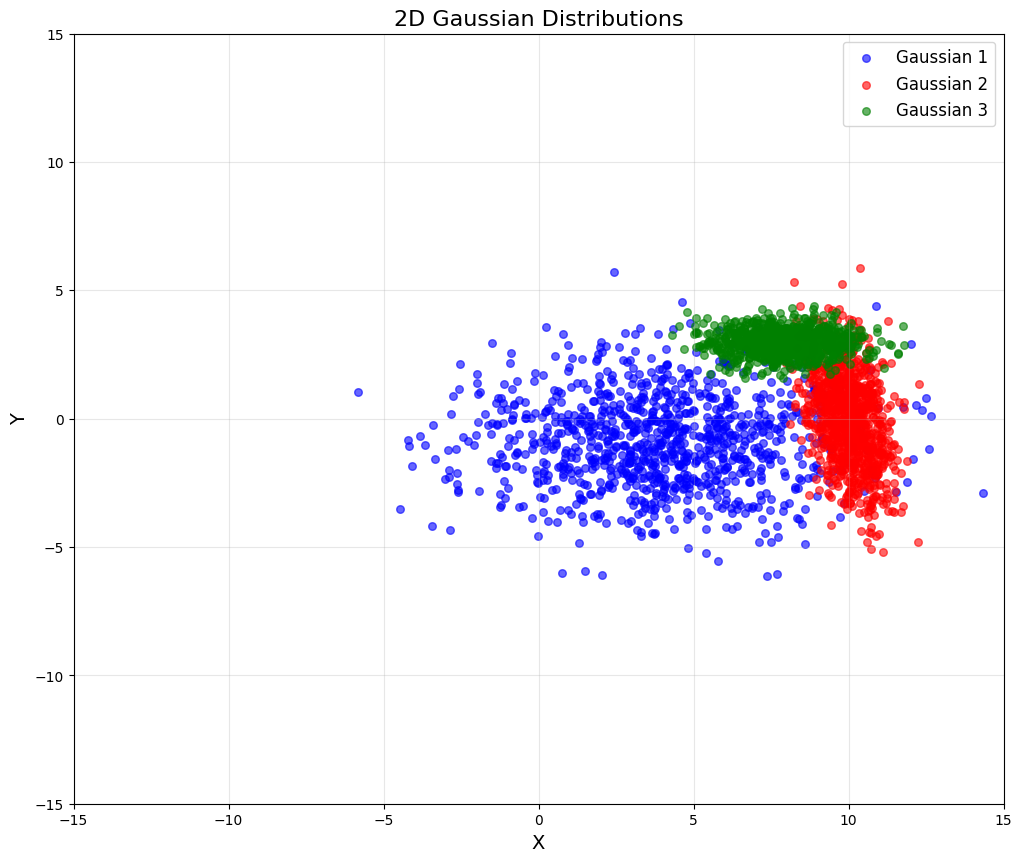

In [280]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class GaussianDataset2D(Dataset):
    def __init__(self, n_samples=10000, random_seed=42):
        np.random.seed(random_seed)

        # Define parameters for 3 Gaussian distributions in 2D
        self.means = [
            [4, -1],  # Mean for Gaussian 1
            [10.0, 0.0],    # Mean for Gaussian 2
            [8.0, 3.0]     # Mean for Gaussian 3
        ]

        # Covariance matrices for each Gaussian
        self.covs = [
            [[10.0, 0.5], [-2, 3.0]],     # Covariance for Gaussian 1
            [[0.5, -0.5], [-0.5, 3.0]],   # Covariance for Gaussian 2
            [[1.5, 0.0], [0.0, 0.2]]      # Covariance for Gaussian 3
        ]

        # Number of samples per Gaussian
        samples_per_gaussian = n_samples // 3

        # Generate data from each Gaussian
        data = []
        labels = []

        for i in range(0, 3):
            gaussian_samples = np.random.multivariate_normal(
                mean=self.means[i],
                cov=self.covs[i],
                size=samples_per_gaussian
            )

            data.append(gaussian_samples)
            labels.append(np.full(samples_per_gaussian, i))  # Labels are 1, 2, or 3

        # Combine data from all Gaussians
        self.data = np.vstack(data).astype(np.float32)
        self.labels = np.concatenate(labels).astype(np.int32)

        # Shuffle the data
        indices = np.arange(len(self.data))
        np.random.shuffle(indices)
        self.data = self.data[indices]
        self.labels = self.labels[indices]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.labels[idx])

def prior_sampling(batch_size, device='cpu'):
    """
    Sampling initial data from p_prior for 2D Gaussian distributions.
    Adapted from PFGM's image-based implementation.
    """
    # Basic parameters
    max_z = config.sampling.z_max  # Maximum z value
    N = 2 + 1     # 2D data + 1 extra dimension

    # Sampling from inverse-beta distribution
    samples_norm = np.random.beta(a=N / 2. - 0.5, b=0.5, size=batch_size)
    inverse_beta = samples_norm / (1 - samples_norm)

    # Sampling from p_radius(R) by change-of-variable
    samples_norm = np.sqrt(max_z ** 2 * inverse_beta)

    # Clip the sample norm (radius)
    upper_norm = config.sampling.upper_norm  # Adjust as needed
    samples_norm = np.clip(samples_norm, 1, upper_norm)
    samples_norm = torch.from_numpy(samples_norm).to(device).view(batch_size, -1)

    # Uniformly sample the angle direction
    gaussian = torch.randn(batch_size, N - 1).to(device)  # N-1 = 2 dimensions
    unit_gaussian = gaussian / torch.norm(gaussian, p=2, dim=1, keepdim=True)

    # Radius times the angle direction
    init_samples = unit_gaussian * samples_norm

    return init_samples.float()

# Create dataset and generate samples from prior

def create_gaussian_dataloader(batch_size=64, n_samples=3000):
    dataset = GaussianDataset2D(n_samples=n_samples)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset, dataloader


def visualize_gaussian_and_prior(n_samples=1000, prior_samples=500):
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Create Gaussian dataset
    dataset = GaussianDataset2D(n_samples=n_samples)

    # Generate samples from prior
    # prior_data = prior_sampling(prior_samples).numpy()

    # Create the plot
    plt.figure(figsize=(12, 10))

    # Plot Gaussian distributions
    colors = ['blue', 'red', 'green']
    markers = ['o', 'o', 'o']
    labels = ['Gaussian 1', 'Gaussian 2', 'Gaussian 3']

    for i in range(0, 3):
        mask = dataset.labels == i
        plt.scatter(
            dataset.data[mask, 0],
            dataset.data[mask, 1],
            c=colors[i],
            marker=markers[i],
            alpha=0.6,
            label=labels[i],
            s=30
        )

    # # Plot prior samples
    # plt.scatter(
    #     prior_data[:, 0],
    #     prior_data[:, 1],
    #     c='purple',
    #     marker='x',
    #     alpha=0.7,
    #     label='Prior Samples',
    #     s=40
    # )

    plt.title('2D Gaussian Distributions', fontsize=16)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Adjust axis limits to show all points clearly
    # plt.xlim(-5, 13)
    # plt.ylim(-7.5, 7.5)
    plt.xlim(-15, 15)
    plt.ylim(-15, 15)
    plt.show()

# Run the visualization
visualize_gaussian_and_prior(n_samples=3000, prior_samples=500)

In [245]:
def visualize_gaussian_and_prior_3d_with_trajectories(dataset, prior_data, labels, trajectories=None, title = 'smt'):
    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Create Gaussian dataset
    # dataset = GaussianDataset2D(n_samples=n_samples)

    # Generate samples from prior
    # prior_data = prior_sampling(prior_samples).numpy()

    # Create the 3D plot
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Gaussian distributions with z=0
    colors = ['blue', 'red', 'green']
    markers = ['o', 'o', 'o']
    classes = ['Gaussian 1', 'Gaussian 2', 'Gaussian 3']

    for i in range(0, 3):
        mask = labels == i
        # All Gaussian points have z=0
        z_values = np.zeros(np.sum(mask))

        ax.scatter(
            dataset.data[mask, 0],
            dataset.data[mask, 1],
            z_values,
            c=colors[i],
            marker=markers[i],
            alpha=0.6,
            label=classes[i],
            s=30
        )

    # Plot prior samples with z=config.sampling.z_max
    z_values_prior = np.ones(len(prior_data)) * config.sampling.z_max

    ax.scatter(
        prior_data[:, 0],
        prior_data[:, 1],
        z_values_prior,
        c='purple',
        marker='x',
        alpha=0.7,
        label='Prior Samples',
        s=40
    )

    # Plot trajectories if provided
    if trajectories is not None:
        for trajectory in trajectories:
            # Each trajectory is a sequence of points showing the evolution
            # Extract x, y coordinates from trajectory points
            xs = [point[0] for point in trajectory]
            ys = [point[1] for point in trajectory]

            # Calculate z values based on the position in the trajectory
            # Start at z_max and linearly decrease to 0
            num_points = len(trajectory)
            zs = [config.sampling.z_max * (1 - i/(num_points-1)) for i in range(num_points)]

            # Plot the trajectory as a line
            ax.plot(xs, ys, zs, 'k-', alpha=0.3, linewidth=1)

    plt.title(title, fontsize=16)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_zlabel('Z', fontsize=14)
    plt.legend(fontsize=12)

    # Adjust axis limits for better visualization
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_zlim(0, config.sampling.z_max * 1.1)

    # Set a good viewing angle
    ax.view_init(elev=20, azim=45)

    plt.show()

# Example usage:
# trajectories should be a list of trajectory paths, where each trajectory is a list of [x,y] coordinates
# trajectories = [
#     [[x0, y0], [x1, y1], ..., [xn, yn]],  # Trajectory 1
#     [[x0, y0], [x1, y1], ..., [xn, yn]],  # Trajectory 2
#     ...
# ]
# visualize_gaussian_and_prior_3d_with_trajectories(n_samples=3000, prior_samples=500, trajectories=trajectories)

<ipython-input-243-ccf04a426246>:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_samples = np.random.multivariate_normal(


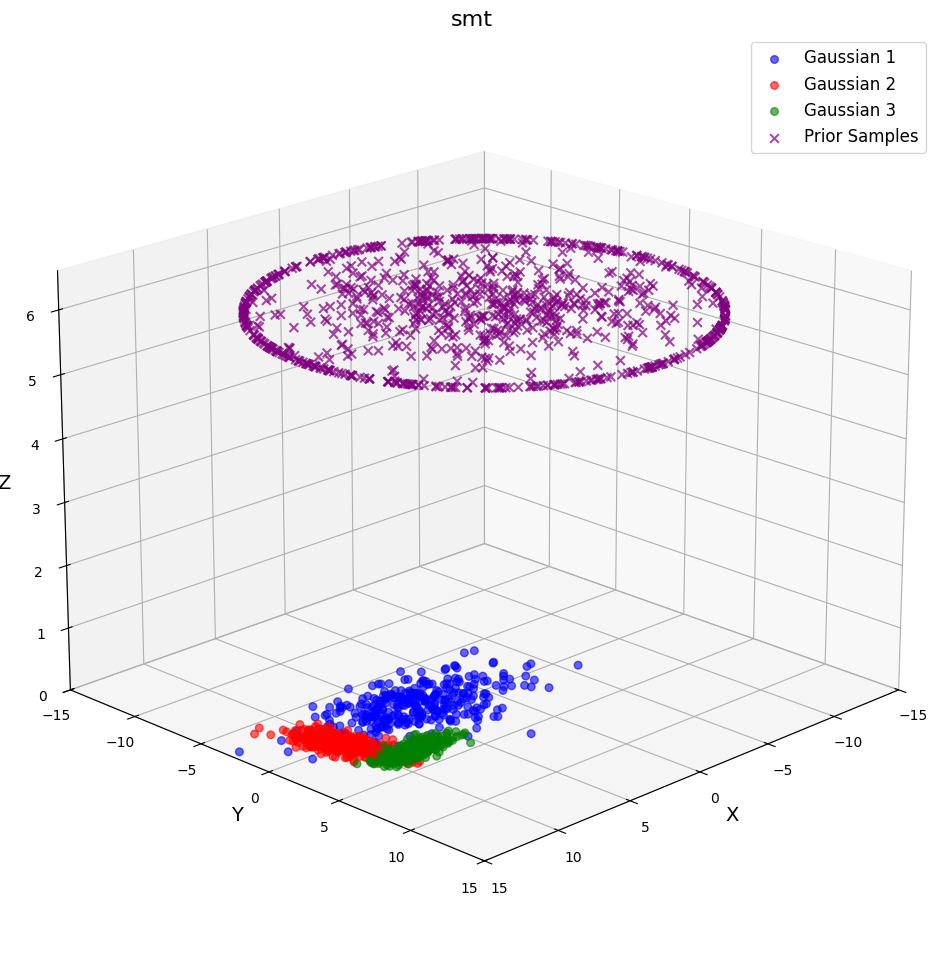

In [246]:
ds = GaussianDataset2D(n_samples=1000)

prior = prior_sampling(1000).numpy()
labels = ds.labels
visualize_gaussian_and_prior_3d_with_trajectories(ds, prior, labels)

In [254]:
def visualize_gaussian_and_prior_3d_with_trajectories(dataset, prior_data, labels, trajectories=None, title='3D Visualization', z_max=config.sampling.z_max):
    """
    Visualize Gaussian distributions, prior samples, and trajectories in 3D.
    View is changed to (z,x,y) so dataset appears on right (z=0) and prior on left (z=z_max).

    Parameters:
    - dataset: Dataset containing the Gaussian points
    - prior_data: Array of prior sample points
    - labels: Array of class labels for the Gaussian points
    - trajectories: List of trajectory points showing the complete path for each point
    - title: Plot title
    - z_max: Maximum z value for prior samples
    """
    # Create the 3D plot
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Plot Gaussian distributions with z=0
    colors = ['blue', 'red', 'green']
    markers = ['o', 'o', 'o']
    classes = ['Gaussian 1', 'Gaussian 2', 'Gaussian 3']

    # Convert dataset to numpy array
    data_array = dataset.numpy()

    # Plot each Gaussian class
    for i in range(3):
        mask = labels == i
        # Skip if no points in this class
        if not np.any(mask):
            continue

        # All Gaussian points have z=0
        z_values = np.zeros(np.sum(mask))

        # Note: changed order to (z,x,y) instead of (x,y,z)
        ax.scatter(
            z_values,           # z=0 for all Gaussian points (now first parameter)
            data_array[:, 0][mask],  # x values (now second parameter)
            data_array[:, 1][mask],  # y values (now third parameter)
            c=colors[i],
            marker=markers[i],
            alpha=0.6,
            label=classes[i],
            s=30
        )

    # Plot prior samples with z=z_max
    z_values_prior = np.ones(len(prior_data)) * z_max

    # Note: changed order to (z,x,y) instead of (x,y,z)
    ax.scatter(
        z_values_prior,      # z=z_max for all prior points (now first parameter)
        prior_data[:, 0],    # x values (now second parameter)
        prior_data[:, 1],    # y values (now third parameter)
        c='purple',
        marker='x',
        alpha=0.7,
        label='Prior Samples',
        s=40
    )

    # Plot trajectories if provided
    if trajectories is not None:
        # Plot a subset of trajectories (e.g., first 25) to avoid visual clutter
        max_trajectories = min(100, len(trajectories[0]))

        for idx in range(max_trajectories):
            # Extract the path for this specific point across all time steps
            z_values = [traj[idx][2] for traj in trajectories]  # z values (now first parameter)
            x_values = [traj[idx][0] for traj in trajectories]  # x values (now second parameter)
            y_values = [traj[idx][1] for traj in trajectories]  # y values (now third parameter)

            # Plot the full trajectory path with new axis order
            ax.plot(z_values, x_values, y_values, 'k-', alpha=0.3, linewidth=0.5)

    plt.title(title, fontsize=16)
    # Update axis labels to reflect new orientation
    ax.set_xlabel('Z', fontsize=14)  # Z is now horizontal (left to right)
    ax.set_ylabel('X', fontsize=14)  # X is the second dimension
    ax.set_zlabel('Y', fontsize=14)  # Y is the third dimension
    plt.legend(fontsize=12)

    # Adjust axis limits for better visualization - flipping z axis direction
    ax.set_xlim(z_max * 1.01, 0)  # Z axis flipped: z_max on left, 0 on right
    ax.set_ylim(-15, 15)  # X axis
    ax.set_zlim(-15, 15)  # Y axis

    # Set a good viewing angle for this new orientation
    ax.view_init(elev=20, azim=-60)  # Adjusted viewing angle to see from right perspective

    plt.show()

In [255]:


dataset, train_loader = create_gaussian_dataloader(batch_size=config.training.batch_size)



<ipython-input-243-ccf04a426246>:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  gaussian_samples = np.random.multivariate_normal(


In [259]:
net = ScoreNetwork_new().to(config.device)

params = net.parameters()
optimizer = torch.optim.Adam(params,
                       lr=config.optim.lr, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                       weight_decay=config.optim.weight_decay)

state = dict(optimizer=optimizer, model=net, step=0)
sde = Poisson(config=config)
sampling_eps = config.sampling.z_min
optimize_fn = optimization_manager(config)
reduce_mean = config.training.reduce_mean

num_train_steps = config.training.n_iters

print(f"Модель имеет {sum(p.numel() for p in net.parameters())} параметров")

Модель имеет 109123 параметров


In [ ]:



initial_step = 0
for step in tqdm(range(initial_step, num_train_steps + 1)):

    train_iter = iter(train_loader)
    batch, labels =  next(train_iter)
    # labels_ohc = (labels[:, None] == torch.arange(3, device=labels.device)[None, :]).float()

    labels = labels
    batch = batch

    # optimizer = state['optimizer']
    optimizer.zero_grad()

    loss = loss_pfgm(net, batch.to(config.device), labels = labels.to(config.device), num_classes = 3, uncond_prob=0.25)
    loss.backward()
    state['step'] += 1
    # wandb.log({"loss train":loss.item()},step=step)

    optimize_fn(optimizer, net.parameters(), step=state['step'])


    if step % 1000 == 0:
        print(f'loss = {loss}')
        shape = (60, 2)

        labels = torch.zeros(shape[0], 3).cpu()
        idxs = np.random.randint(low=0, high=3, size=shape[0])
        labels[np.arange(shape[0]), idxs] = 1



        sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
        sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = 0, save_traj = True)


        colors = ['blue', 'red', 'green']
        markers = ['o', 'o', 'o']

        visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'cfg = {0}')



        sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
        sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = 0.1, save_traj = True)


        visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'cfg = {0.1}')


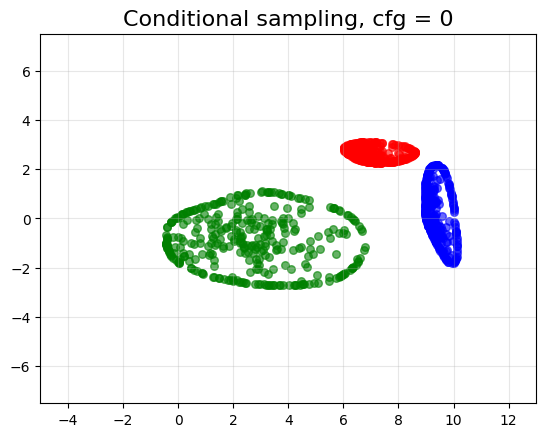

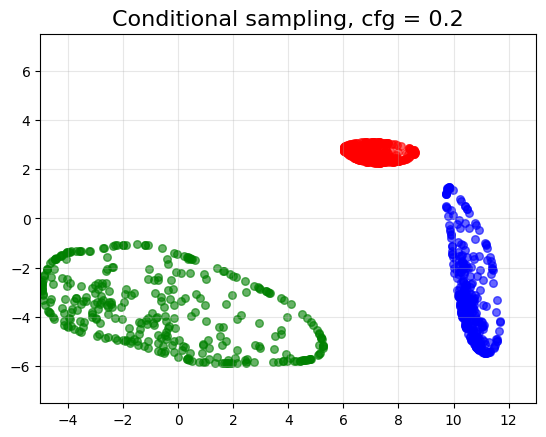

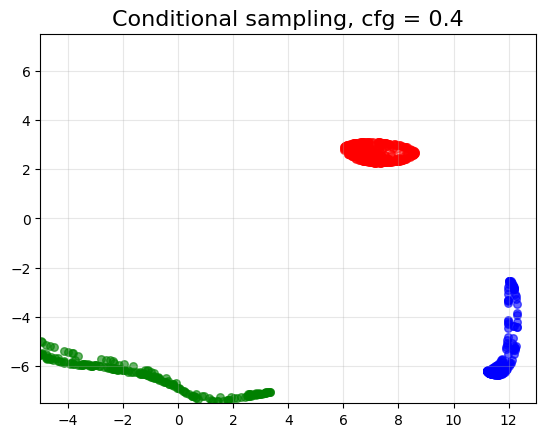

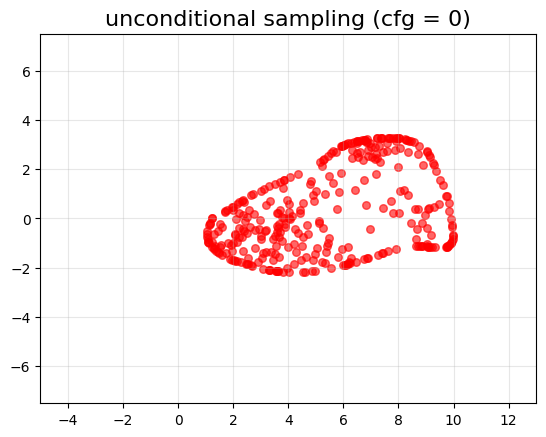

In [ ]:
    shape = (1000, 2)

    labels = torch.zeros(1000, 3).cpu()
    idxs = np.random.randint(low=0, high=3, size=1000)
    labels[np.arange(1000), idxs] = 1



    sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
    sample, n = sampling_fn(net, class_labels = labels, cfg = 0)


    colors = ['blue', 'red', 'green']
    markers = ['o', 'o', 'o']

    for i in range(0, 3):
        mask = idxs == i
        plt.scatter(
            sample[:, 0].cpu().detach().numpy()[mask],
            sample[:, 1].cpu().detach().numpy()[mask],
            c=colors[i-1],
            marker=markers[i-1],
            alpha=0.6,
            label=labels[i-1],
            s=30
        )
    plt.xlim(-5, 13)
    plt.ylim(-7.5, 7.5)
    plt.title(f'Conditional sampling, cfg = {0}', fontsize=16)
    plt.grid(alpha=0.3)
    plt.show()


    sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
    sample, n = sampling_fn(net, class_labels = labels, cfg = 0.2)


    for i in range(0, 3):
        mask = idxs == i
        plt.scatter(
            sample[:, 0].cpu().detach().numpy()[mask],
            sample[:, 1].cpu().detach().numpy()[mask],
            c=colors[i-1],
            marker=markers[i-1],
            alpha=0.6,
            label=labels[i-1],
            s=30
        )

    plt.title(f'Conditional sampling, cfg = {0.2}', fontsize=16)
    plt.grid(alpha=0.3)

    plt.xlim(-5, 13)
    plt.ylim(-7.5, 7.5)
    plt.show()


    sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
    sample, n = sampling_fn(net, class_labels = labels, cfg = 0.4)


    for i in range(0, 3):
        mask = idxs == i
        plt.scatter(
            sample[:, 0].cpu().detach().numpy()[mask],
            sample[:, 1].cpu().detach().numpy()[mask],
            c=colors[i-1],
            marker=markers[i-1],
            alpha=0.6,
            label=labels[i-1],
            s=30
        )

    plt.title(f'Conditional sampling, cfg = {0.4}', fontsize=16)
    plt.grid(alpha=0.3)

    plt.xlim(-5, 13)
    plt.ylim(-7.5, 7.5)
    plt.show()




    shape = (1000, 2)

    labels = torch.zeros(1000, 4).cpu()
    idxs = -1
    labels[np.arange(1000), idxs] = 1



    sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
    sample, n = sampling_fn(net, class_labels = labels, cfg = 0)

    plt.scatter(
        sample[:, 0].cpu().detach().numpy()[mask],
        sample[:, 1].cpu().detach().numpy()[mask],
        c=colors[i-1],
        marker=markers[i-1],
        alpha=0.6,
        label=labels[i-1],
        s=30
    )
    plt.title(f'unconditional sampling (cfg = 0)', fontsize=16)
    plt.grid(alpha=0.3)

    plt.xlim(-5, 13)
    plt.ylim(-7.5, 7.5)
    plt.show()


<ipython-input-238-98e1407fc033>:89: RuntimeWarning: invalid value encountered in log
  trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t) * np.ones(new_shape[0]), axis = 1)), axis = 1))


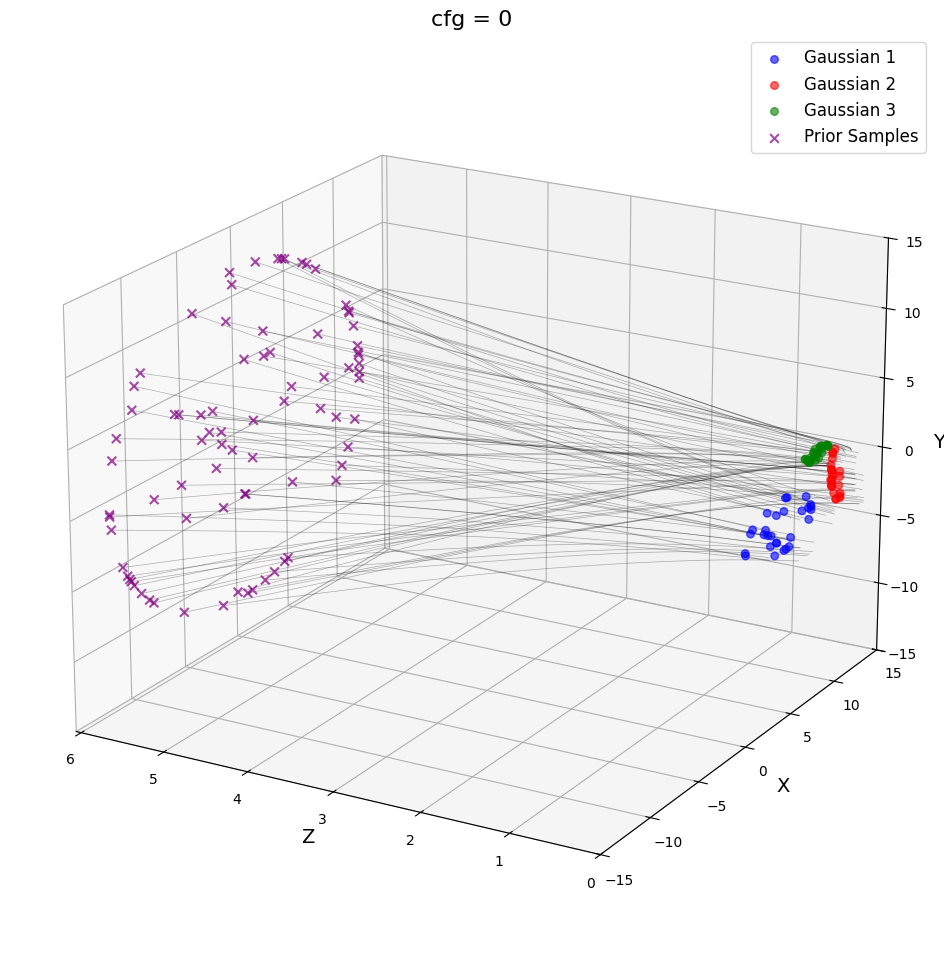

In [273]:
cfg = 0
shape = (80, 2)

labels = torch.zeros(shape[0], 3).cpu()
idxs = np.random.randint(low=0, high=3, size=shape[0])
labels[np.arange(shape[0]), idxs] = 1



sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = cfg, save_traj = True)


colors = ['blue', 'red', 'green']
markers = ['o', 'o', 'o']

visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'Conditinal sampling, cfg = {cfg}')


<ipython-input-238-98e1407fc033>:89: RuntimeWarning: invalid value encountered in log
  trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t) * np.ones(new_shape[0]), axis = 1)), axis = 1))


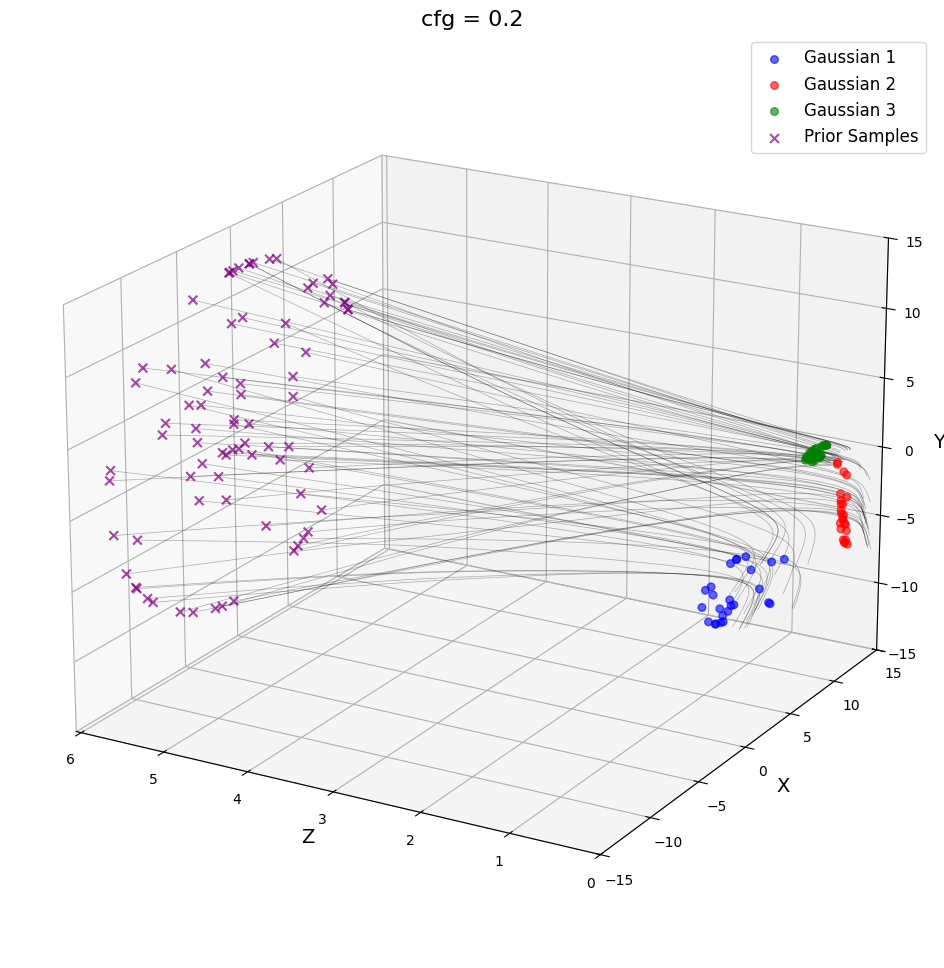

In [274]:
cfg = 0.2
shape = (80, 2)

labels = torch.zeros(shape[0], 3).cpu()
idxs = np.random.randint(low=0, high=3, size=shape[0])
labels[np.arange(shape[0]), idxs] = 1



sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = cfg, save_traj = True)


colors = ['blue', 'red', 'green']
markers = ['o', 'o', 'o']

visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'Conditional sampling, cfg = {cfg}')


<ipython-input-238-98e1407fc033>:89: RuntimeWarning: invalid value encountered in log
  trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t) * np.ones(new_shape[0]), axis = 1)), axis = 1))


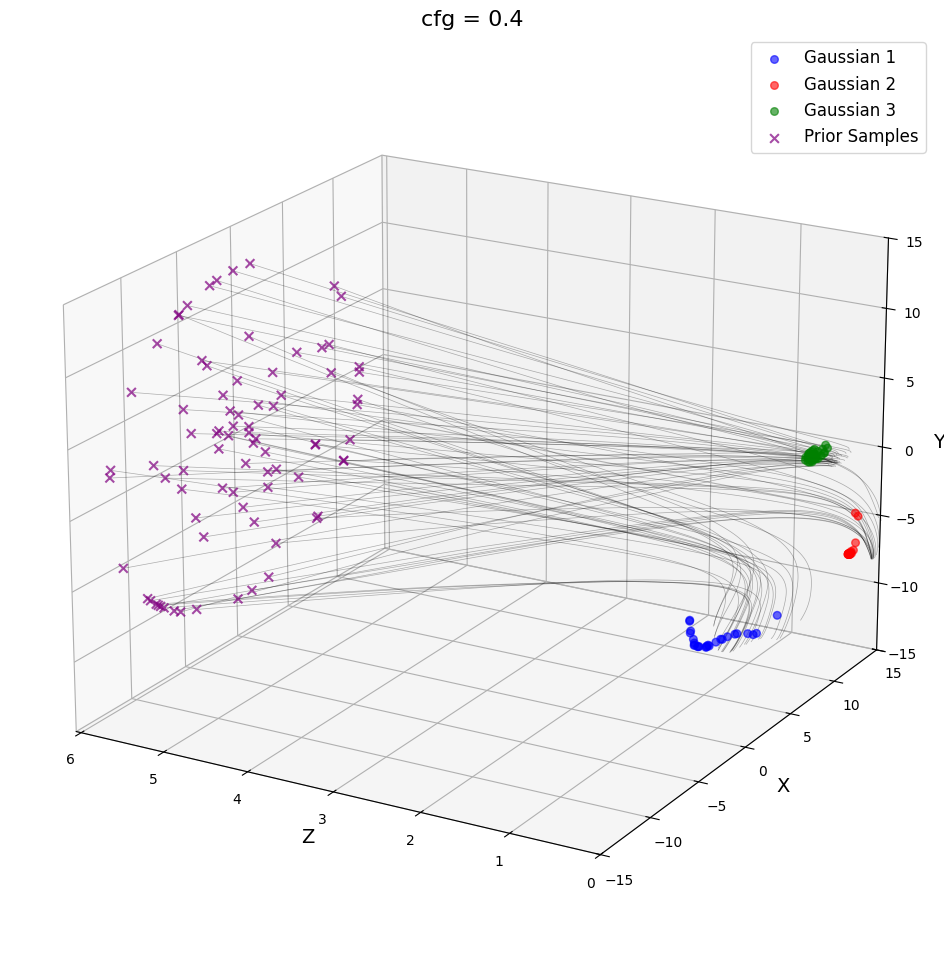

In [277]:
cfg = 0.4
shape = (80, 2)

labels = torch.zeros(shape[0], 3).cpu()
idxs = np.random.randint(low=0, high=3, size=shape[0])
labels[np.arange(shape[0]), idxs] = 1



sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = cfg, save_traj = True)


colors = ['blue', 'red', 'green']
markers = ['o', 'o', 'o']

visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'Conditional sampling, cfg = {cfg}')


<ipython-input-238-98e1407fc033>:89: RuntimeWarning: invalid value encountered in log
  trajectory.append(np.concatenate((x_flat.reshape(new_shape), np.expand_dims(np.log(t) * np.ones(new_shape[0]), axis = 1)), axis = 1))


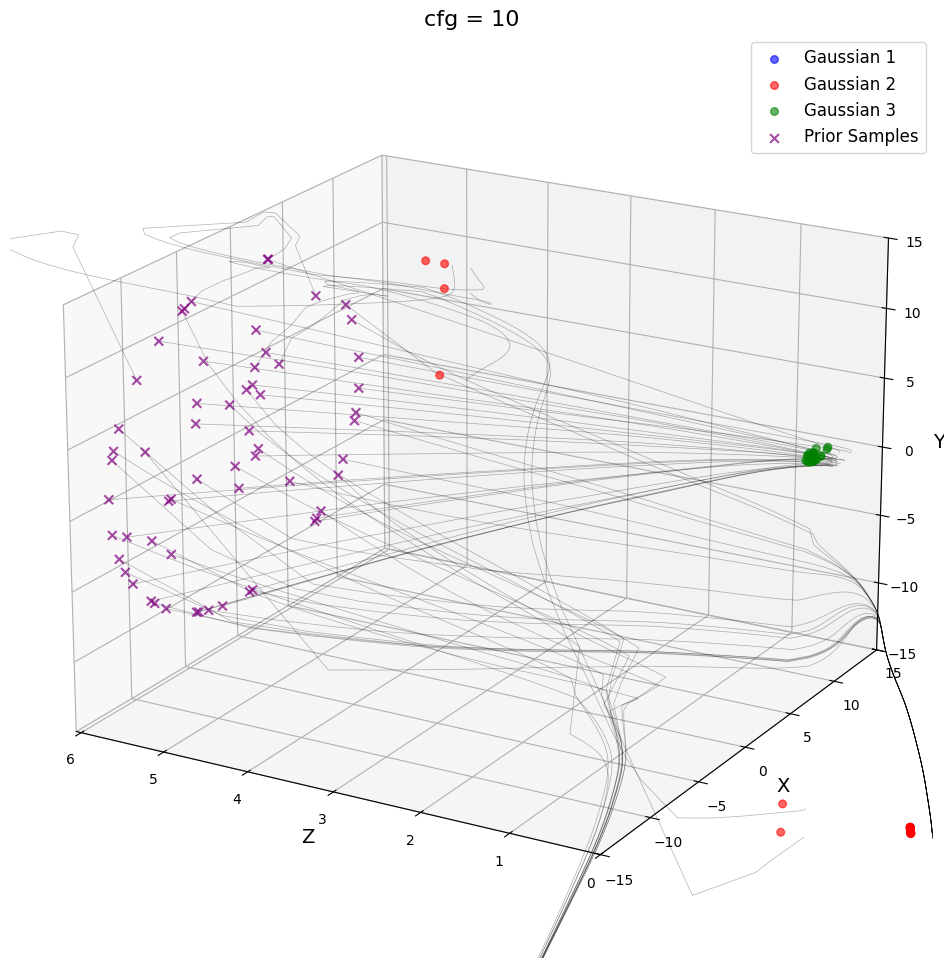

In [261]:
cfg = 10
shape = (60, 2)

labels = torch.zeros(shape[0], 3).cpu()
idxs = np.random.randint(low=0, high=3, size=shape[0])
labels[np.arange(shape[0]), idxs] = 1



sampling_fn = get_euler_sampler_pfgm(sde, shape, num_steps=100, eps=1e-3, device='cpu')
sample, prior, traj = sampling_fn(net, class_labels = labels, cfg = cfg, save_traj = True)


colors = ['blue', 'red', 'green']
markers = ['o', 'o', 'o']

visualize_gaussian_and_prior_3d_with_trajectories(sample, prior, idxs, traj, title = f'Conditional sampling, cfg = {cfg}')
